In [1]:
import torch
from torch.utils.data import DataLoader
from src.model.mapsed import MAPSED
from src.model.vae.conv_vae import ConvVAE
from src.utils.calculate_seq_loss import calculate_seq_loss
from src.utils.load_data import load_seq_data, \
    normalize_data_tensor, recover_data_tensor, normalize_data
import numpy as np
import pandas as pd


In [2]:
def evaluate(dataloader, model, metric):
    targets = []
    predicts = []
    inputs = []
    for idx, seq in enumerate(dataloader):
        # print("updating with data [{}/{}]".format(idx+1, len(dataloader_train)))
        #32,13,4,10,10
        seq = seq.cuda().float()
        x = seq[:, :5]
        gt = seq[:, 5:]
        y_pred = model(x)[0].data
        inputs.append(x)
        predicts.append(y_pred)
        targets.append(gt)
    predicts = torch.cat(predicts)
    targets = torch.cat(targets)
    inputs = torch.cat(inputs)
    loss = {m: None for m in metric}
    for m in metric:
        loss[m] = calculate_seq_loss(predicts, targets, m)
    loss_means = {m: loss[m].mean(axis=0) for m in metric}
    loss_vars = {m: loss[m].var(axis=0) for m in metric}
    loss_mean_and_var = {m: np.stack([loss_means[m], loss_vars[m]])
                         for m in metric}
    return loss, loss_mean_and_var, predicts, targets, inputs

In [3]:
def predict(seq, model, max_tensor):
    output = []
    # print("updating with data [{}/{}]".format(idx+1, len(dataloader_train)))
    #32,13,4,10,10
    seq = torch.tensor(seq).cuda().float()
    x = seq[:, :5]
    y_pred = model(x)[0].data
    output.append(recover_data_tensor(y_pred, max_tensor))
    output = torch.cat(output)
    return output


In [4]:
device = torch.device('cuda')
vae = ConvVAE(input_channels=4).to(device)
vae.load_state_dict(
    torch.load('../../saved_models/SF/VAE-SF.torch'))
m = 5
n = 3

model = MAPSED(vae, latent_shape=(2, 5, 5), m=m, n=n,
               lambda_contrast=10, contrast='L2',lambda_MAE=1).to(device)
model.load_state_dict(torch.load('../../saved_models/SF/MAPSED.torch'))
model.training = False
model.eval()
vae.eval()
vae.training = False
seq_train, _, seq_test = load_seq_data('SF')

# mean_tensor = torch.tensor(seq_train.mean(axis=(0,1,3,4))).cuda().float()
# mean = seq_train.mean(axis=(0,1,3,4))
max = np.array([seq_train[:,:,i].max() for i in range(4)])
max_tensor = torch.tensor(max).cuda().float()
print(max)

[142 130  88  63]


# Semantics learning

In [5]:
seq_test.mean(axis=(0,1,3,4))

array([6.05075728, 4.34592262, 3.18660714, 2.56311673])

In [6]:
seq_test = seq_test[:32]
N, l, c, w, h = seq_test.shape
seq_test_noramlized = normalize_data(seq_test, max)
seq_test_one_channel_val = np.sum(seq_test_noramlized, axis=2, keepdims=True)
seq_test_one_channel_0 = np.concatenate((seq_test_one_channel_val,
                                      np.zeros((N,l,c-1,w,h))),
                                      axis=2)
seq_test_one_channel_1 = np.concatenate((np.zeros((N,l,1,w,h)),
                                       seq_test_one_channel_val,
                                      np.zeros((N,l,c-2,w,h))),
                                      axis=2)
seq_test_one_channel_2 = np.concatenate((np.zeros((N,l,2,w,h)),
                                       seq_test_one_channel_val,
                                      np.zeros((N,l,c-3,w,h))),
                                      axis=2)
seq_test_one_channel_3 = np.concatenate((np.zeros((N,l,3,w,h)),
                                       seq_test_one_channel_val),
                                      axis=2)



seq_test_one_channels = [seq_test_one_channel_0,
                         seq_test_one_channel_1,
                         seq_test_one_channel_2,
                         seq_test_one_channel_3]

In [7]:
import seaborn as sn
from matplotlib import pyplot as plt

def plot_predictions(predicts, name, vmax=None):
    fig, axn = plt.subplots(4,3, sharex=True, sharey=True, figsize=(5,5))
    cbar_ax = fig.add_axes([.99, .3, .03, .4])
    idx = 1
    for i in range(4):
        for t in range(3):
            # plt.subplot(4, 3, (t+ 3*i + 1))
            if vmax is None:
                vmax = np.round(predicts.cpu().max())
            sn.heatmap(predicts.view(-1,3,4,10,10).cpu()[0,t,i],
                       cmap='Spectral',vmax=vmax, ax=axn.flat[idx-1],
                       cbar_ax=cbar_ax,xticklabels=False, yticklabels=False)
            idx += 1
    fig.tight_layout()
    plt.savefig('{}.pdf'.format(name))
    return None



In [8]:
predicts_array = []

In [9]:
# test_data_loader= DataLoader(seq_test, batch_size=32, shuffle=True, drop_last=True)
metric = ['MAE']
predicts = predict(seq_test, model, max_tensor)
print(predicts.mean(dim=(0,1,3,4)))
# plot_predictions(predicts, 'predict_normal',vmax=75)


print(predicts[0,:,0].max())

print(predicts[0,:,1].max())

print(predicts[0,:,2].max())

print(predicts[0,:,3].max())

tensor([6.0598, 3.7279, 2.7458, 1.9031], device='cuda:0')
tensor(72.9161, device='cuda:0')
tensor(57.5714, device='cuda:0')
tensor(35.2479, device='cuda:0')
tensor(31.1531, device='cuda:0')


In [10]:
predicts = predict(seq_test_one_channels[0], model, max_tensor)
print(predicts.mean(dim=(0,1,3,4)))
predicts_array.append(predicts)
# plot_predictions(predicts, 'predict_channel_{}'.format(0), vmax=120)
print(predicts[0,:,0].max())

print(predicts[0,:,1].max())

print(predicts[0,:,2].max())

print(predicts[0,:,3].max())

tensor([10.3142,  2.3798,  3.2421,  1.2021], device='cuda:0')
tensor(118.1784, device='cuda:0')
tensor(35.8848, device='cuda:0')
tensor(35.5344, device='cuda:0')
tensor(23.8480, device='cuda:0')


In [11]:
predicts = predict(seq_test_one_channels[1], model, max_tensor)
print(predicts.mean(dim=(0,1,3,4)))
# plot_predictions(predicts, 'predict_channel_{}'.format(1),vmax=115)
predicts_array.append(predicts)
print(predicts[0,:,0].max())

print(predicts[0,:,1].max())

print(predicts[0,:,2].max())

print(predicts[0,:,3].max())

tensor([5.0907, 6.3872, 2.1799, 2.3917], device='cuda:0')
tensor(55.9771, device='cuda:0')
tensor(108.7566, device='cuda:0')
tensor(34.5223, device='cuda:0')
tensor(37.8921, device='cuda:0')


In [12]:
predicts = predict(seq_test_one_channels[2], model, max_tensor)
print(predicts.mean(dim=(0,1,3,4)))
# plot_predictions(predicts, 'predict_channel_{}'.format(2),vmax=45)

predicts_array.append(predicts)
# print(predicts[0,:,0].max())
#
# print(predicts[0,:,1].max())
#
# print(predicts[0,:,2].max())
#
# print(predicts[0,:,3].max())
print(predicts[0,0,0].max())

print(predicts[0,0,1].max())

print(predicts[0,0,2].max())

print(predicts[0,0,3].max())

tensor([5.9138, 2.9351, 4.7105, 1.2772], device='cuda:0')
tensor(59.1640, device='cuda:0')
tensor(44.9171, device='cuda:0')
tensor(62.8745, device='cuda:0')
tensor(19.0368, device='cuda:0')


In [13]:
predicts = predict(seq_test_one_channels[3], model, max_tensor)
print(predicts.mean(dim=(0,1,3,4)))
# plot_predictions(predicts, 'predict_channel_{}'.format(3),vmax=35)

print(predicts[0,0,0].max())

print(predicts[0,0,1].max())

print(predicts[0,0,2].max())

print(predicts[0,0,3].max())
predicts_array.append(predicts)

tensor([4.9931, 4.7795, 2.6755, 4.4460], device='cuda:0')
tensor(51.0355, device='cuda:0')
tensor(40.7688, device='cuda:0')
tensor(24.3804, device='cuda:0')
tensor(60.9171, device='cuda:0')


In [14]:
print(predicts[0,0,0].max())

print(predicts[0,0,1].max())

print(predicts[0,0,2].max())

print(predicts[0,0,3].max())

tensor(51.0355, device='cuda:0')
tensor(40.7688, device='cuda:0')
tensor(24.3804, device='cuda:0')
tensor(60.9171, device='cuda:0')


In [15]:
predicts.shape


torch.Size([32, 3, 4, 10, 10])

In [16]:
predicts_all = torch.stack(predicts_array)

print(predicts_all.shape)
predicts_all = predicts_all[:,0,0]
predicts_all = predicts_all.transpose(0,1)
# plt.savefig('{}.pdf'.format(name))

torch.Size([4, 32, 3, 4, 10, 10])


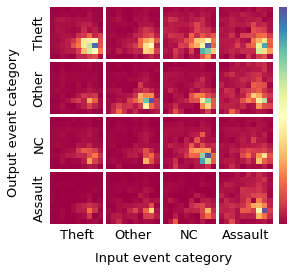

In [17]:
fig, axn = plt.subplots(4,4,sharex=True, sharey=True, figsize=(4,4))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.92, .125, .03, .755])
idx = 1
vmax_array = [118,100,60,60]
for i in range(4):
    for t in range(4):
        # plt.subplot(4, 3, (t+ 3*i + 1))
        vmax = vmax_array[t]
        if idx == 11:
            sn.heatmap(predicts_all.cpu()[i,t],
                       cmap='Spectral',vmax=vmax,
                       ax=axn.flat[idx-1],
                       cbar_kws={'ticks':[]},
                       cbar_ax=cbar_ax,
                       xticklabels=False, yticklabels=False)
        else:
            sn.heatmap(predicts_all.cpu()[i,t],
                       cmap='Spectral',vmax=vmax,
                       ax=axn.flat[idx-1],
                       cbar=False,
                       xticklabels=False, yticklabels=False)
        idx += 1


axn.flat[0].set_ylabel('Theft',fontsize=13)
axn.flat[4].set_ylabel('Other', fontsize=13)
axn.flat[8].set_ylabel('NC',fontsize=13)
axn.flat[12].set_ylabel('Assault',fontsize=13)

axn.flat[12].set_xlabel('Theft',rotation='horizontal',fontsize=13)
# axn.flat[0].xaxis.set_label_position('top')
axn.flat[13].set_xlabel('Other',rotation='horizontal',fontsize=13)
# axn.flat[1].xaxis.set_label_position('top')
axn.flat[14].set_xlabel('NC',rotation='horizontal',fontsize=13)
# axn.flat[2].xaxis.set_label_position('top')
axn.flat[15].set_xlabel('Assault',rotation='horizontal',fontsize=13)
# axn.flat[3].xaxis.set_label_position('top')

fig.suptitle('Input event category',fontsize=13,x=0.52,y=0.03)
fig.align_ylabels(axn[:0])
fig.text(0,0.48, 'Output event category',rotation='vertical',
         va='center',ha='center',fontsize=13)
plt.autoscale()

# plt.tight_layout()

plt.savefig('SF-semantics.pdf',bbox_inches='tight')


# Dynamics: move around


In [18]:
seq_test_noramlized = normalize_data(seq_test,max)
N, l, c, w, h = seq_test_noramlized.shape
seq_test_one_space_values = np.max(seq_test_noramlized, axis=(3,4))
seq_test_one_space = np.zeros(seq_test_noramlized.shape)

for i in range(5):
    seq_test_one_space[:,i,:,i+3,i+3] = seq_test_one_space_values[:,i]
# seq_test_one_space

In [19]:
# seq_test_one_space[0,4,0].nonzero()
# seq_test_one_space_values[0,:,0]

In [20]:
#3,4,10,10
pred = predict(seq_test_one_space[:32],model,max_tensor).cpu()
predicts_d=np.array(pred)[0]
predicts_d = predicts_d.reshape((-1,100))
predicts_d.shape

(12, 100)

In [21]:
mask_values = np.array([predicts_d[i][np.argsort(predicts_d[i])][-2]
               for i in range(12)])
mask_values = np.stack([mask_values for _ in range(100)], axis=1)
mask_values.shape

(12, 100)

In [22]:
# pred_d_new_maksed = []
masked = predicts_d.copy()
masked[masked<mask_values] = 0
masked = masked.reshape((3,4,10,10))

In [23]:
obs = seq_test_one_space[0,:5]
data = np.concatenate([obs,masked],axis=0).transpose((1,0,2,3))
data.shape

(4, 8, 10, 10)

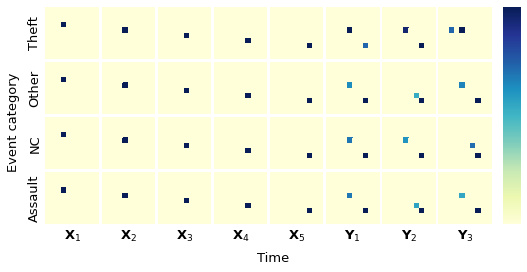

In [24]:
fig, axn = plt.subplots(4,8,sharex=True,sharey=True, figsize=(8,4))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
cbar_ax = fig.add_axes([.92, .125, .03, .755])
idx = 1
for i in range(4):
    for t in range(8):
        if idx == 31:
            sn.heatmap(data[i,t],
                       cmap='YlGnBu',
                       ax=axn.flat[idx-1],
                       cbar_kws={'ticks':[]},
                       cbar_ax=cbar_ax,
                       xticklabels=False, yticklabels=False)
        else:
            sn.heatmap(data[i,t],
                       cmap='YlGnBu',
                       ax=axn.flat[idx-1],
                       cbar=False,
                       xticklabels=False, yticklabels=False)
        idx += 1


axn.flat[0].set_ylabel('Theft',fontsize=13)
axn.flat[8].set_ylabel('Other', fontsize=13)
axn.flat[16].set_ylabel('NC',fontsize=13)
axn.flat[24].set_ylabel('Assault',fontsize=13)


axn.flat[24].set_xlabel('$\mathbf{X}_1$',rotation='horizontal',fontsize=13)
axn.flat[25].set_xlabel('$\mathbf{X}_2$',rotation='horizontal',fontsize=13)
axn.flat[26].set_xlabel('$\mathbf{X}_3$',rotation='horizontal',fontsize=13)
axn.flat[27].set_xlabel('$\mathbf{X}_4$',rotation='horizontal',fontsize=13)
axn.flat[28].set_xlabel('$\mathbf{X}_5$',rotation='horizontal',fontsize=13)
axn.flat[29].set_xlabel('$\mathbf{Y}_1$',rotation='horizontal',fontsize=13)
axn.flat[30].set_xlabel('$\mathbf{Y}_2$',rotation='horizontal',fontsize=13)
axn.flat[31].set_xlabel('$\mathbf{Y}_3$',rotation='horizontal',fontsize=13)

fig.suptitle('Time',fontsize=13,x=0.52,y=0.03)
fig.align_ylabels(axn[:0])
fig.text(0.07,0.48, 'Event category',rotation='vertical',
         va='center',ha='center',fontsize=13)
plt.autoscale()

# plt.tight_layout()

plt.savefig('SF-dynamics.pdf',bbox_inches='tight')